In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import lightgbm as lgb

In [7]:
# Load and Preprocess
# ==============================
file_path = "preprocessed_air_quality.csv"
df = pd.read_csv(file_path)

if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

df = df.fillna(df.median(numeric_only=True))

if 'Date' in df.columns:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

def categorize_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy for Sensitive'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

if 'AQI' in df.columns:
    df['AQI_Level'] = df['AQI'].apply(categorize_aqi)

df_encoded = df.copy()
for col in df_encoded.select_dtypes(include=['object']).columns:
    if col not in ['AQI_Level']:
        df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

In [8]:
# Regression Task (XGBoost)
# ==============================
X_reg = df_encoded.drop(columns=['Date', 'AQI', 'AQI_Level'], errors='ignore')
y_reg = df_encoded['AQI']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

reg_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

param_grid_reg = {
    "n_estimators": [200, 500],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid_reg = GridSearchCV(reg_model, param_grid_reg, cv=3, scoring="r2", n_jobs=-1)
grid_reg.fit(X_train_reg_scaled, y_train_reg)

best_reg = grid_reg.best_estimator_
y_pred_reg = best_reg.predict(X_test_reg_scaled)

print("\n-> Regression Results (XGBoost)")
print(f"Best Params: {grid_reg.best_params_}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test_reg, y_pred_reg):.2f}")
print(f"R² Score: {r2_score(y_test_reg, y_pred_reg):.2f}")



-> Regression Results (XGBoost)
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Mean Squared Error (MSE): 6617.51
R² Score: -0.04


In [9]:
# Classification Task (LightGBM)
# ==============================
X_clf = df_encoded.drop(columns=['Date', 'AQI', 'AQI_Level'], errors='ignore')
y_clf = df['AQI_Level']

label_encoder = LabelEncoder()
y_clf_encoded = label_encoder.fit_transform(y_clf)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf_encoded, test_size=0.2, random_state=42
)

scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)

clf_model = lgb.LGBMClassifier(random_state=42, class_weight="balanced")

param_grid_clf = {
    "n_estimators": [200, 500],
    "learning_rate": [0.05, 0.1],
    "num_leaves": [31, 50],
    "max_depth": [-1, 10, 20],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

grid_clf = GridSearchCV(clf_model, param_grid_clf, cv=3, scoring="accuracy", n_jobs=-1)
grid_clf.fit(X_train_clf_scaled, y_train_clf)

best_clf = grid_clf.best_estimator_
y_pred_clf = best_clf.predict(X_test_clf_scaled)

print("\n-> Classification Results (LightGBM)")
print(f"Best Params: {grid_clf.best_params_}")
print(f"Accuracy: {accuracy_score(y_test_clf, y_pred_clf):.2f}")
print("Classification Report:\n", classification_report(
    y_test_clf, y_pred_clf, target_names=label_encoder.classes_, zero_division=0
))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2068
[LightGBM] [Info] Number of data points in the train set: 2928, number of used features: 13
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438

-> Classification Results (LightGBM)
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 50, 'subsample': 0.8}
Accuracy: 0.30
Classification Report:
                          precision    recall  f1-score   support

                   Good       0.00      0.00      0.00        63
               Moderate       0.22      0.14      0.17       142
              Unhealthy       0.16

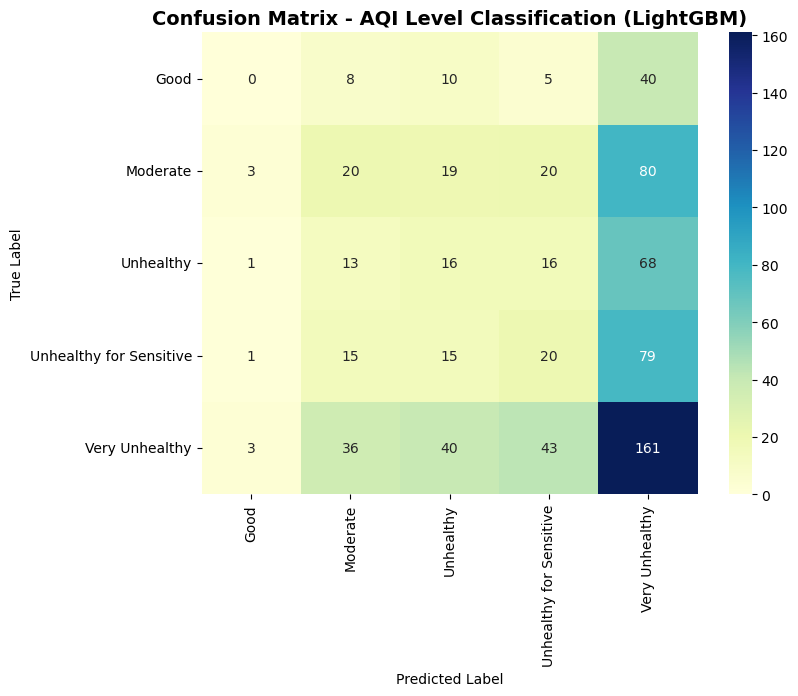

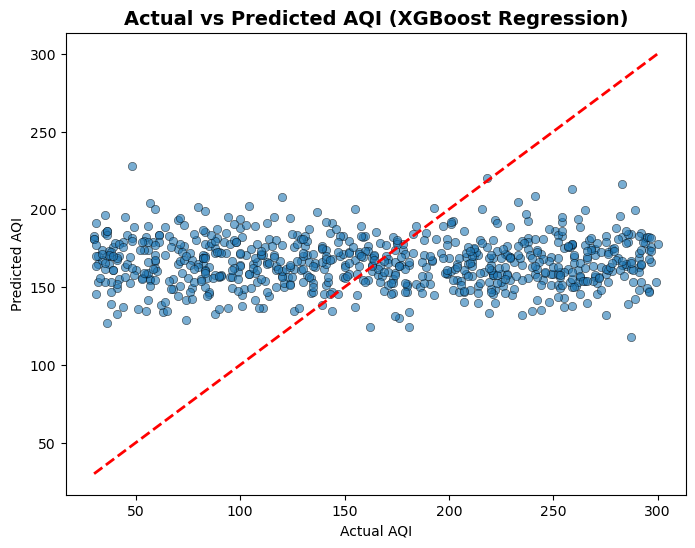

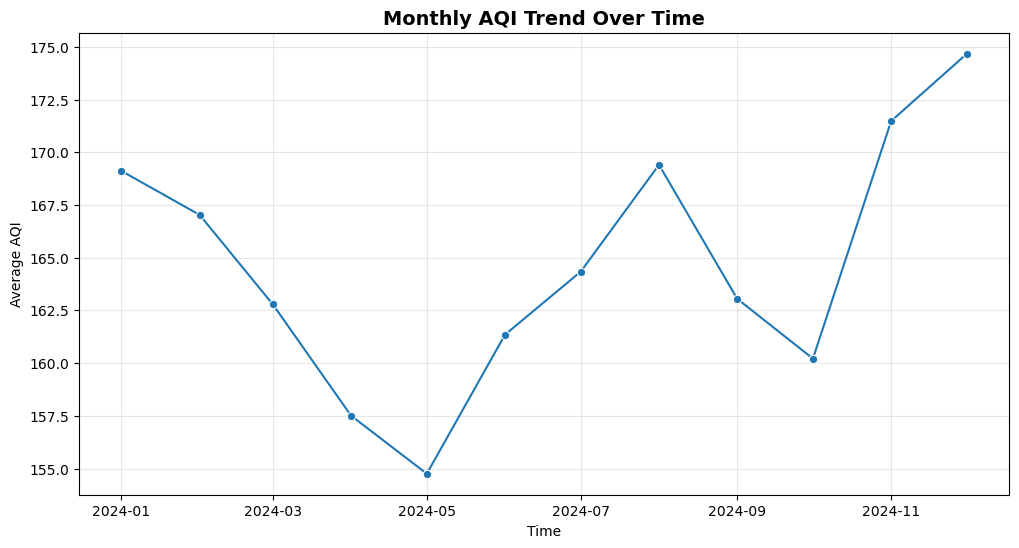

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - AQI Level Classification (LightGBM)", fontsize=14, weight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ==============================
# Visuals
# ==============================
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_reg, y=y_pred_reg, alpha=0.6, edgecolor='k')
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.title("Actual vs Predicted AQI (XGBoost Regression)", fontsize=14, weight='bold')
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.show()

if 'Date' in df.columns:
    plt.figure(figsize=(12,6))
    monthly_trend = df.groupby(['Year','Month'])['AQI'].mean().reset_index()
    monthly_trend['Date'] = pd.to_datetime(monthly_trend[['Year','Month']].assign(DAY=1))
    sns.lineplot(x='Date', y='AQI', data=monthly_trend, marker='o')
    plt.title("Monthly AQI Trend Over Time", fontsize=14, weight='bold')
    plt.xlabel("Time")
    plt.ylabel("Average AQI")
    plt.grid(True, alpha=0.3)
    plt.show()

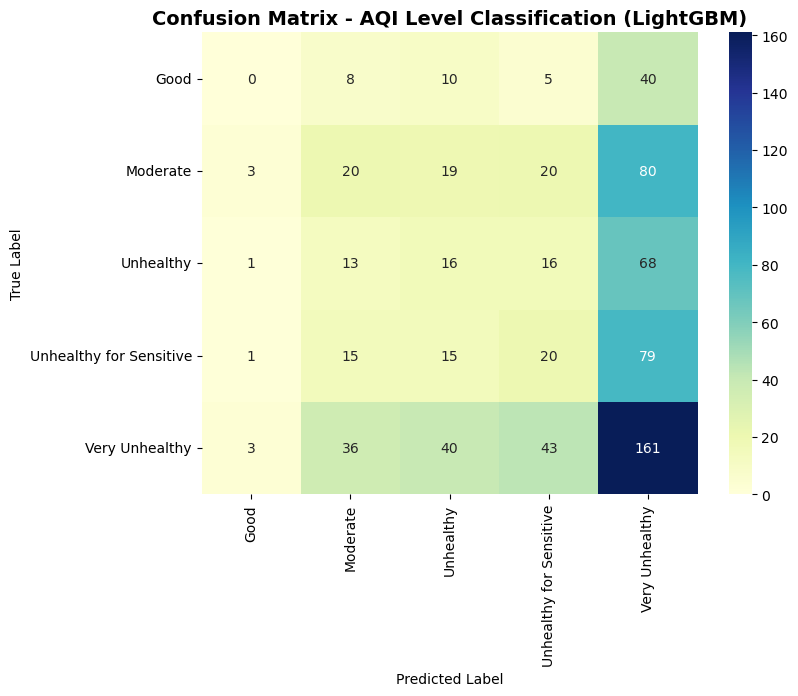

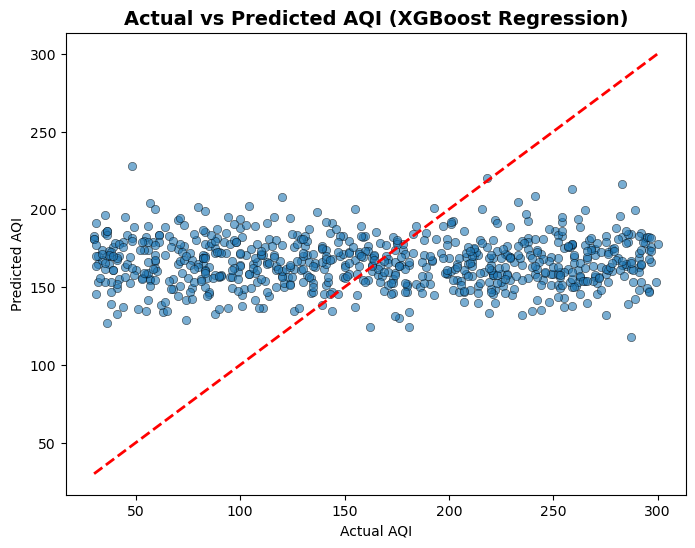

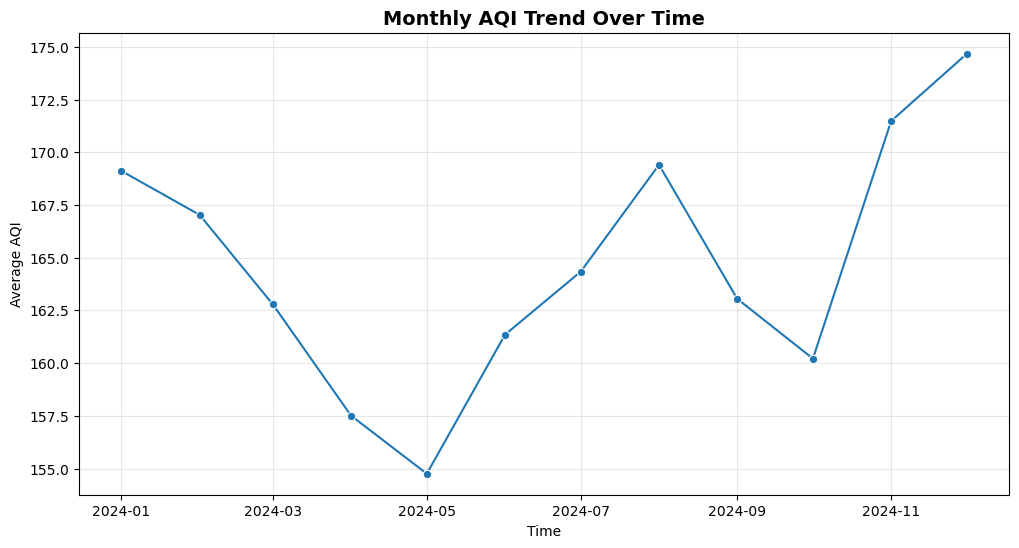

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - AQI Level Classification (LightGBM)", fontsize=14, weight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ==============================
# Visuals
# ==============================
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_reg, y=y_pred_reg, alpha=0.6, edgecolor='k')
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.title("Actual vs Predicted AQI (XGBoost Regression)", fontsize=14, weight='bold')
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.show()

if 'Date' in df.columns:
    plt.figure(figsize=(12,6))
    monthly_trend = df.groupby(['Year','Month'])['AQI'].mean().reset_index()
    monthly_trend['Date'] = pd.to_datetime(monthly_trend[['Year','Month']].assign(DAY=1))
    sns.lineplot(x='Date', y='AQI', data=monthly_trend, marker='o')
    plt.title("Monthly AQI Trend Over Time", fontsize=14, weight='bold')
    plt.xlabel("Time")
    plt.ylabel("Average AQI")
    plt.grid(True, alpha=0.3)
    plt.show()

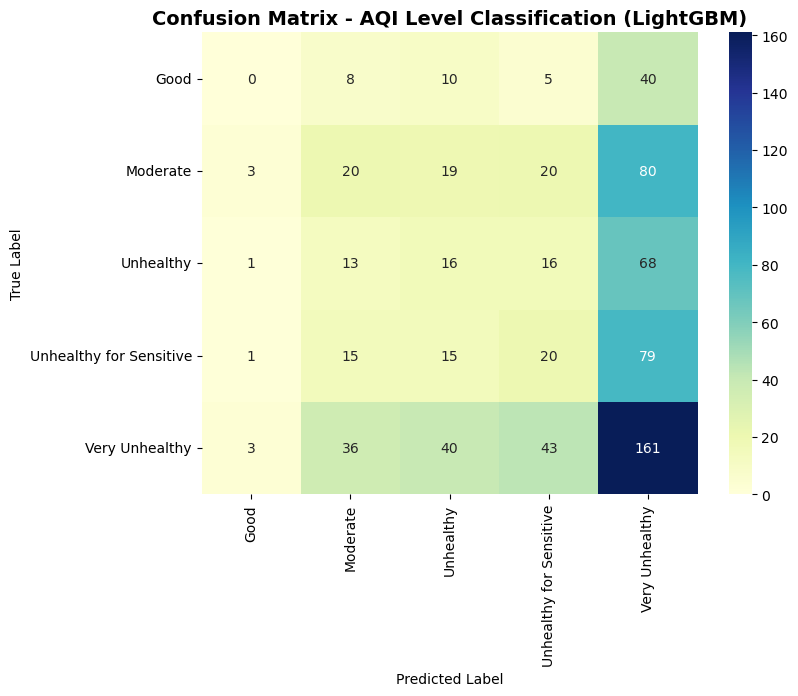

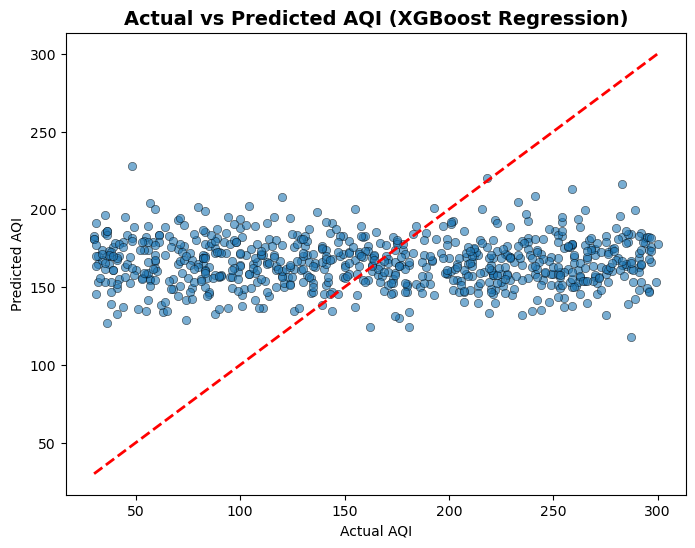

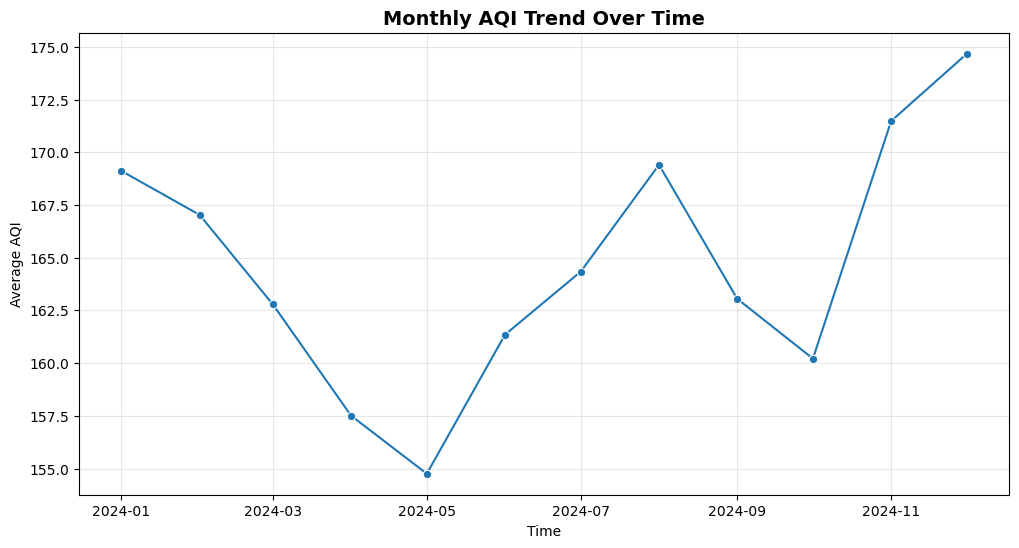

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - AQI Level Classification (LightGBM)", fontsize=14, weight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ==============================
# Visuals
# ==============================
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_reg, y=y_pred_reg, alpha=0.6, edgecolor='k')
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.title("Actual vs Predicted AQI (XGBoost Regression)", fontsize=14, weight='bold')
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.show()

if 'Date' in df.columns:
    plt.figure(figsize=(12,6))
    monthly_trend = df.groupby(['Year','Month'])['AQI'].mean().reset_index()
    monthly_trend['Date'] = pd.to_datetime(monthly_trend[['Year','Month']].assign(DAY=1))
    sns.lineplot(x='Date', y='AQI', data=monthly_trend, marker='o')
    plt.title("Monthly AQI Trend Over Time", fontsize=14, weight='bold')
    plt.xlabel("Time")
    plt.ylabel("Average AQI")
    plt.grid(True, alpha=0.3)
    plt.show()

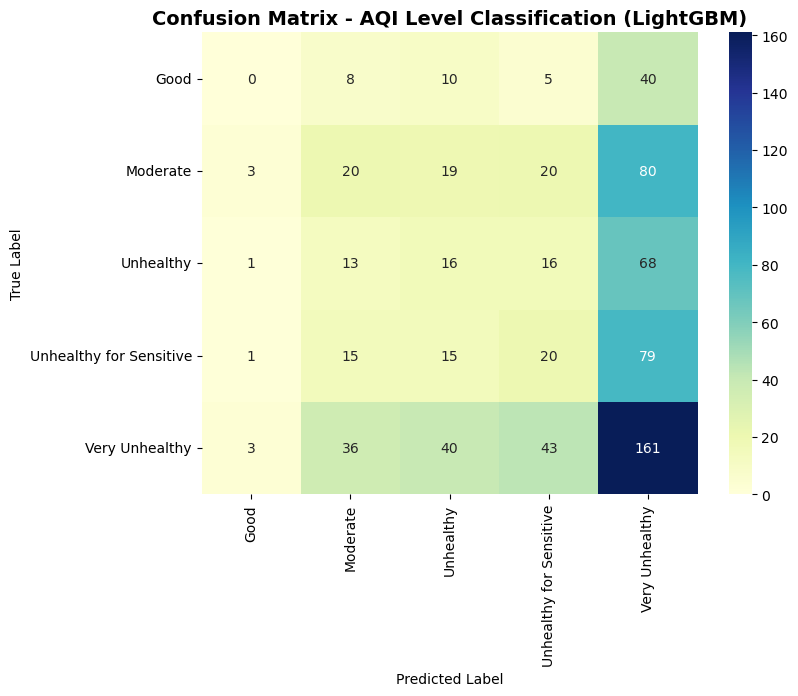

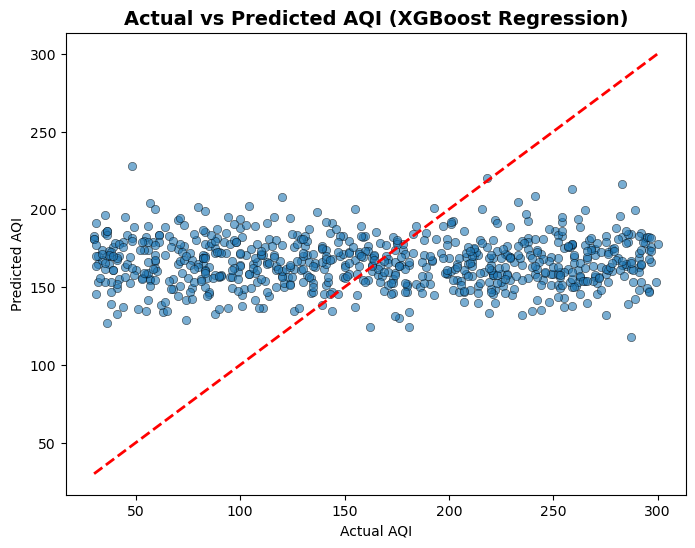

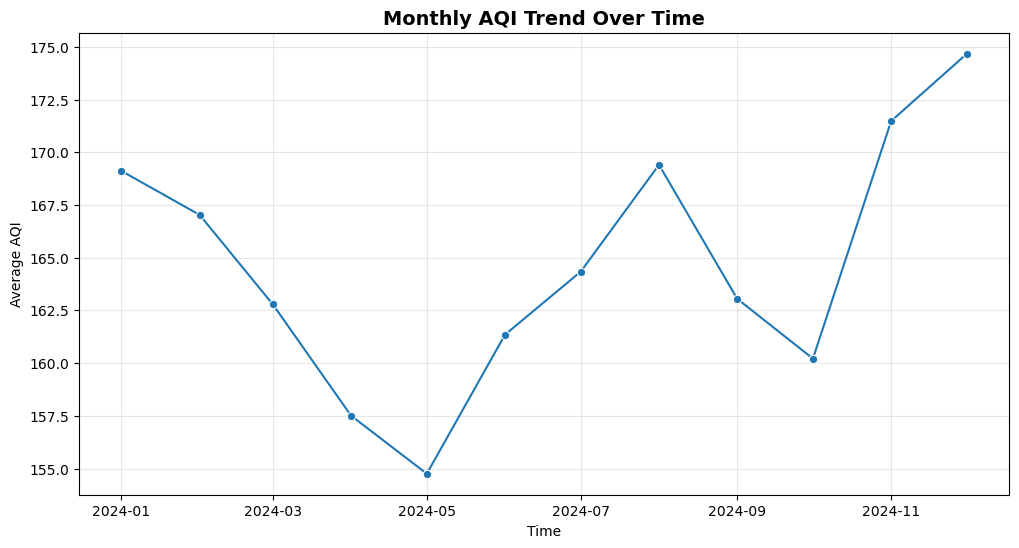

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_clf)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - AQI Level Classification (LightGBM)", fontsize=14, weight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ==============================
# Visuals
# ==============================
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test_reg, y=y_pred_reg, alpha=0.6, edgecolor='k')
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.title("Actual vs Predicted AQI (XGBoost Regression)", fontsize=14, weight='bold')
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.show()

if 'Date' in df.columns:
    plt.figure(figsize=(12,6))
    monthly_trend = df.groupby(['Year','Month'])['AQI'].mean().reset_index()
    monthly_trend['Date'] = pd.to_datetime(monthly_trend[['Year','Month']].assign(DAY=1))
    sns.lineplot(x='Date', y='AQI', data=monthly_trend, marker='o')
    plt.title("Monthly AQI Trend Over Time", fontsize=14, weight='bold')
    plt.xlabel("Time")
    plt.ylabel("Average AQI")
    plt.grid(True, alpha=0.3)
    plt.show()